Yesterday we had a first look at how calcium imaging data looks like. Today we will dive deeper into how to convert that data into clean and meaningful traces that describe the activity of individual neurons. We will structure today by looking at different scenarios in calcium imaging experiments, describing the problems that can arise, and what solutions are on-hand to fix them. 
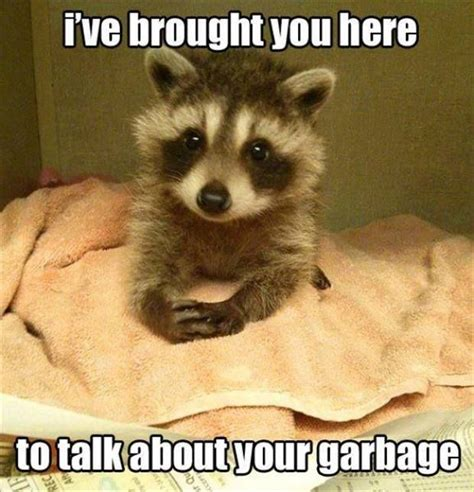
There is a famous saying in data analysis " Garbage in, garbage out" - it basically means no amount of fancy modeling will save you if you don't have good raw data. The aim of today is to help you keep your own data as clean and pretty as possible, and also recognize warning signs in other people's data in papers or collaborations.

### Converting Terabytes to Megabytes
One of the most prominent steps in analyzing your calcium imaging movies is converting it from a set of movies to a set of neural traces. In order to do this, you need to decide which parts of the image belong to individual structures eg neurons. The fancy terms for this are **source extraction**, **cell detection** and **signal extraction**. The less fancy term for this is drawing ROIs, and it was the bane of calcium imaging phds everywhere until some amazing new algorithms popped up in the last 5 years. I'll take you through the basic principles and show you how to do it with simple software. At the end of today's lesson, I'll introduce you to the popular softwares that automate this process.

How to draw ROIs:
1. take the mean image across all frames (sometimes called the _projection_)
2. draw polygons* around the bright bits.
3. take the average of the pixels inside the polygon mask for each frame.
4. string together the averages across all frames
5. congratulations, you have now created a neural activity trace! you have also reduced the size of your data by several orders of magnitude

\*Neurons tend to have a donut shape in these mean images because calcium indicators do not express in the nucleus (unless they are _filled_ and then the activity might get funky).
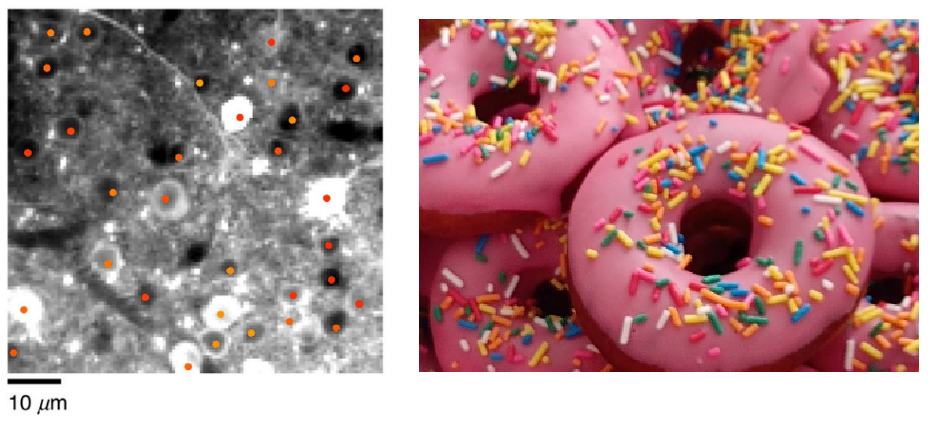
See the resemblance?

One of the simplest softwares for doing this kind of analysis is ImageJ. One of your tasks in the exercises will be to draw some simple ROIs.

......Add already here neuropil, point spread function?.......... 

Let's discuss several experimental scenarios you might encounter in the lab.

### The Multitasking scenario
You listened to the older students advice and started your calcium imaging career with a simple anesthetized experiment to troubleshoot the setup. To keep things simple, you borrow a transgenic mouse that expresses GCaMP6s from your labmate, and plop him under the microscope. You find lots of cells, hooray! So you turn on some drifting gratings to make sure your triggers are working. The whole thing should take 10 minutes, but 2 minutes in, your labmate walks in and asks you if you've seen the oscilloscope. Wanting to repay the favor of the free mouse, you agree to help them hunt it down. 5 minutes later you find it hiding under the sink and come back to your screen. But alas! your screen doesn't look anything like it did before! What happened?

#### The problem:  Drift
Your image will most likely drift slowly over time. This means your whole image slowly translating up/down or left/right. This is fixable. However, you can also get drift in the z-dimension, which means that the landmarks and bright cells in your image slowly disappear. This is much harder, nigh, impossible to correct for in post-processing, because you have no reference for whether cells are dim due to inactivity or drift. (FRET sensors help somewhat with this, but they have other limitations)

#### The solution: Motion correction
Well, the best solution is a combination of online adjustments and post-processing. It is good practice to take an average image of a few hundred frames at the start of your acquisition and keep this as a reference on your screen. You should always be comparing your current acquisition qith your initial average. If you notice that your focal plane has moved, you can adjust it. 

After your data is acquired, you can perform motion correction, or **registration** as a first step in your preprocessing pipeline. The most common form of motion correction works by identifying landmarks in your images, and then comparing the location of these landmarks across images. And added bonus is that this process usually involves creating a copy of your movies in their now motion-corrected, registered state. +1 redundancy, -1 storage space. But remember, this only works when your drift was in the x or y dimension. If the focal plane shifted during your experiment (z-drift), it's time to ring the bells, cuz your data is dead, and unlike Jon Snow, it's not coming back.
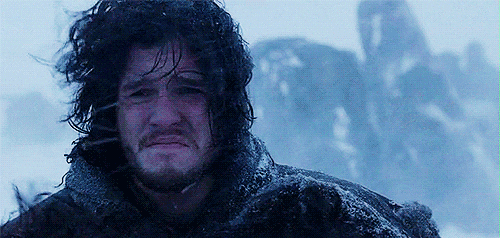

### The leaky light scenario
Imagine that, having learned about the importance of attending to the microscope throughout the recording, you have another go at your experiment. However, just as turns on the laser, the motor moving the mirrors gets stuck. There's nothing for it but to remove the light shielding from the microscope and unstick the mirror. This goes breezily, you re-mount the light shielding and turn on the microscope. But wait. Now you notice that the 2-P image is getting slightly brighter whenever the stimulus is on. What is going on?

#### The Problem: Light contamination
When you are using light as your stimulus, which is very often the case in visual neuroscience, any stray photons can be picked up by the sensitive PMTs in your microscope. You will notice this most likely during the imaging. You can also see it easily in the neural traces, as it will be a square-shaped modulation of the signal during the time of the stimulus, which is very unlike the sharp-rise-slow-decay shape of the calcium transient.
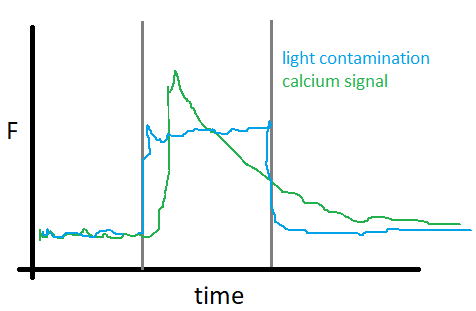


#### The solution: Background subtraction
Ok, well actually the solution to this is to improve your light shielding. This really is an important step, and it's worth the time you put into it, because light contaminated data will never be fully uncontaminated. Alternatively you can also invest in a system where the monitor is turned off during scanning and only is on when the mirrors are turning around. BUT, you can get rid of most of the problem by drawing an ROI around some dark part of the image (usually a vessel, to make sure there will be no activity there) and subtracting this from the rest of your traces.

.... add image of good background candidate .....
Q. when should you subrract, before or after calculating F0?

### The Everything-In-One-Experiment Scenario

Imagine you recently learned about the controversy around mirror neurons and decided you're going to be the first to show mirror neurons in the mouse. You decide you will need to measure many neurons in order to find the elusive mirror neurons, and since you expect they will be in the easy to reach motor cortex, you decide to use calcium imaging to find them. You record hours of movies of mice doing things, express GCaMP7 in mouse M1, put your mouse in front of the TV and fire up the 2P. At the beginning the signals are bright and beautiful. You stay attentive to the microscope, correcting drift as the need arises. But one hour into your mouse movie marathon, you can barely see the neurons. What is happening?! After the experiment, you draw some ROIs and plot their signal over time. 
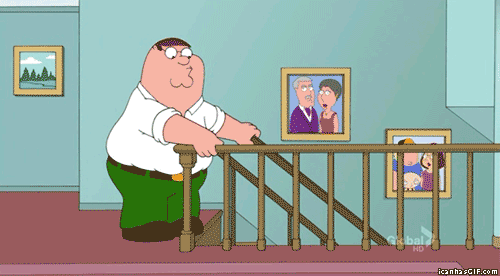
Down they go!

#### The problem: Bleaching
Just like your favorite purple t-shirt, fluorophores bleach. After too much light exposure, some of your GCaMP molecules will be bleached and will no longer be able to fluoresce. Normally, they are replaced with fresh new GCaMP, but when you record for a long time, there is no more stock of fresh GCaMP, so your signal decreases. Also, note that some fluorophores, like RGECO, bleach more than others[1]. 

#### The solution: Normalize your F trace. ΔF
Let me introduce you to ΔF : this is the most common unit for calcium imaging traces. The equation for it is:

$$\Delta F = \frac{F-F_{0}}{F_{0}}$$

The reason you normalize by F<sub>0</sub> is to control for several parameters, such as the amount of calcium indicator present in the cell. This changes from cell to cell just based on how much they express your fluorophore, but it also changes over time because of photobleaching. 
##### Common ways to calculate F<sub>0</sub> 
1. take a percentile of your trace in a moving window. This will allow it to adapt to slow fluctuations in overall fluorescence. This leaves you with 2 free paramters that you need to choose: The percentile, and the size of the moving window. Both of these are a bit of an art. + **Window size** : You want to make sure that your window size is large enough to not be affected by individual bursts of activity, but small enough so that you are tracking well the fluctuations in baseline. Often 30-60s is used.
+ **Percentile** : This will depend on the expected activity of whatever you're imaging. If you expect very sparse activity, this value will be large eg 50-70%, because you expect your trace to be at baseline most of the time. If you expect frequenct activity, than this value should be fairly low eg 20-30% because your trace will be at baseline relatively infrequently. There are some algorithms that try to fit the percentile dynamically to each cell depending on activity. Every experiment is different, and the choice of how to calculate will ultimately be up to you. 
2. use the trial baseline. This is recommended only in cases where you think your neuron really shouldn't be active before your stimulus eg in sparsely active neurons like cortical L2/3. 

**NB**: an alternative to ΔF is to use a z-score, which can also be adapted to change over time and accommodate a bleaching fluorophore.

.... Perfect fodder for a widget where they can play with percentile and window to see effect on dF......

How to know if you chose well? 
+ negative ΔF
+ ΔF above 0 at baseline

### The movement artifact scenario

### Neuropil

### The deconvolution scenario

1. Walker, Burrone and Meyer. 2013. Functional imaging in the zebrafish retinotectal system using RGECO. Front. Neural Circuits | https://doi.org/10.3389/fncir.2013.00034